## Imports

In [18]:
import IPython.display as ipd
from scipy.signal import hilbert
import numpy as np
from scipy.stats import skew
import pandas as pd
import matplotlib.pyplot as plt
# change style
plt.style.use('ggplot')
import librosa
import librosa.display
from tqdm import tqdm
tqdm.pandas()
import os
from glob import glob
import random

from concurrent.futures import ThreadPoolExecutor, as_completed

In [3]:
from params import SOUNDS_DATASET_PATH, SAMPLE_RATE


## Notes

> L'utilisation du logarithme dans un problème de classification audio a plusieurs avantages :

- Perception auditive : L'échelle de perception de l'intensité sonore par l'oreille humaine est logarithmique. Cela signifie que notre perception de l'intensité sonore augmente de manière non linéaire par rapport à l'énergie du son. En utilisant le logarithme du RMS, nous transformons les valeurs d'énergie en une échelle qui reflète mieux notre perception du volume sonore.

- Normalisation : Les valeurs de RMS peuvent varier considérablement en fonction de l'amplitude du signal audio. En utilisant le logarithme, nous réduisons cette variation et normalisons les valeurs dans une plage plus restreinte, facilitant ainsi la comparaison entre différents signaux audio et améliorant la performance de classification.

- Traitement du signal numérique : L'utilisation du logarithme peut également aider à éviter les problèmes de précision numérique et de sous-échantillonnage lors du traitement des signaux audio. Les signaux audio peuvent présenter une dynamique importante, et le logarithme permet de gérer cette dynamique de manière plus robuste.

## Load dataset

In [4]:
dataset_csv_path = os.path.join(SOUNDS_DATASET_PATH, 'dataset.csv')
dataset = pd.read_csv(dataset_csv_path)
dataset

,file_path,file_name,file_extension,class,split
0,G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...,Clap 0000,.flac,Clap,train
1,G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...,Clap 0001,.flac,Clap,train
2,G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...,Clap 0002,.flac,Clap,test
3,G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...,Clap 0003,.flac,Clap,test
4,G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...,Clap 0004,.flac,Clap,train
...,...,...,...,...,...
7635,G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...,Tom 0995,.flac,Tom,train
7636,G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...,Tom 0996,.flac,Tom,test
7637,G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...,Tom 0997,.flac,Tom,train
7638,G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...,Tom 0998,.flac,Tom,train


## Listen one audio

In [6]:
def display_audio(file_path):
    ext = file_path.split('.')[-1]
    # change file_path : keep only parent folder / file name
    print(">",os.path.join(os.path.basename(os.path.dirname(file_path)), os.path.basename(file_path)))
    if ext in ['flac']:
        y, sr = librosa.load(file_path, sr=44100)
        return ipd.display(ipd.Audio(y, rate=sr))
    else:
        return ipd.display(ipd.Audio(file_path))

display_audio(dataset['file_path'][1])
y1,sr1 = librosa.load(dataset['file_path'][1], sr=SAMPLE_RATE)

display_audio(dataset['file_path'][5000])
y2,sr2 = librosa.load(dataset['file_path'][5000], sr=SAMPLE_RATE)
display_audio(dataset['file_path'][random.randint(0, len(dataset))])

> Clap\Clap 0001.flac


> Ride\Ride 0100.flac


> Snare\Snare 0707.flac


## Feature extraction

### Duration

In [10]:
def get_duration(y, sr):
    """
    Calcule la durée d'un signal audio.

    Args:
        y (np.ndarray): Le signal audio.
        sr (int): Le taux d'échantillonnage du signal audio.

    Returns:
        float: La durée du signal audio.
    """

    return librosa.get_duration(y=y, sr=sr)

def get_duration_from_file_path(file_path : str, sr=SAMPLE_RATE):
    y, sr = librosa.load(file_path, sr=sr)
    return get_duration(y, sr)

get_duration(y1, sr1)

1.1

In [11]:
get_duration_from_file_path(dataset['file_path'][1])

1.1

### Root Mean Square (RMS)

- **Average, max, and standard deviation of log RMS** : RMS is root mean squared energy, which you can just think of as volume
measures how intense the audio’s peaks are. Peak RMS divided by average RMS.
- **Average change in RMS** : since we compute RMS per frame of audio (each frame is ~23 ms in my implementation), we can also look at how it goes up and down between frames. This is also true for other features in this list.
- **Crest factor** : measures how intense the audio’s peaks are. Peak RMS divided by average RMS.

In [90]:
def log_rms_stats(y, frame_length=1024, hop_length=512):
    """
    Calcule les statistiques du RMS d'un signal audio.

    Args:
        y (np.ndarray): Le signal audio.
        frame_length (int, optional): La taille de la fenêtre. Defaults to 1024. Dans cette fenêtre, on calcule le RMS, c'est à dire la racine carrée de la moyenne des carrés des échantillons.
        hop_length (int, optional): Le pas de la fenêtre (la distance entre deux fenêtres consécutives). Defaults to 512.
    """
    rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)
    log_rms = np.log10(rms)

    log_rms_diff = np.diff(log_rms) # shape = (1, n_frames - 1)
    log_avg_rms = np.mean(log_rms)
    log_peak_rms = np.max(log_rms)

    log_crest_factor = log_peak_rms / log_avg_rms

    return {
        'log_mean_rms': log_avg_rms,
        'log_max_rms': log_peak_rms,
        'log_rms_std': np.std(log_rms),
        'log_rms_diff_mean': np.mean(np.abs(log_rms_diff)),
        'log_crest_factor': log_crest_factor
    }, log_rms

log_rms_stats(y1)[0]

{'log_mean_rms': -2.7017295,
 'log_max_rms': -0.5925827,
 'log_rms_std': 1.3132565,
 'log_rms_diff_mean': 0.078257196,
 'log_crest_factor': 0.21933457}

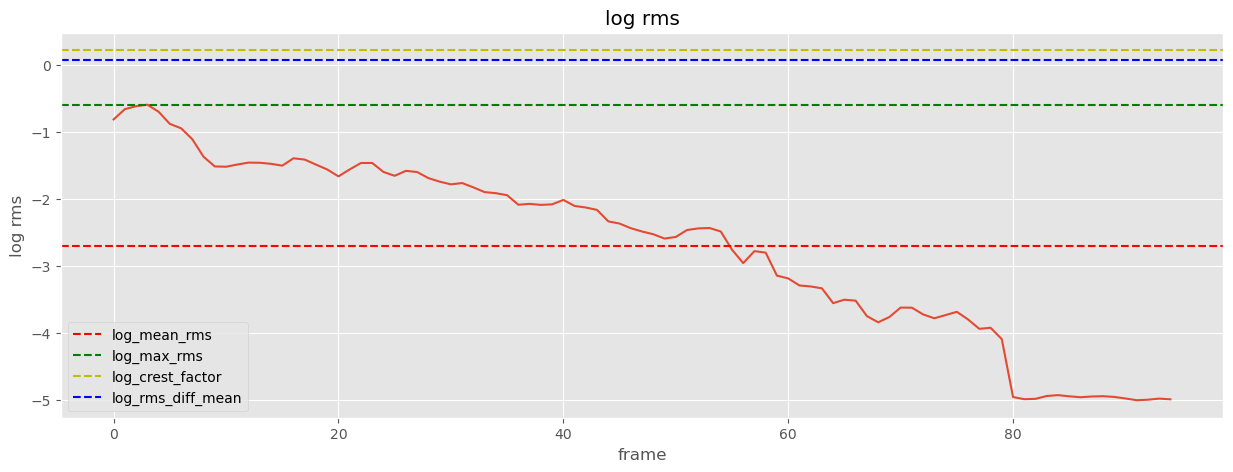

In [97]:
# plot log rms
rms_stats, log_rms  = log_rms_stats(y1)
plt.figure(figsize=(15, 5))
plt.plot(log_rms[0])
plt.axhline(rms_stats['log_mean_rms'], color='r', linestyle='--', label='log_mean_rms')
plt.axhline(rms_stats['log_max_rms'], color='g', linestyle='--', label='log_max_rms')
plt.axhline(rms_stats['log_crest_factor'], color='y', linestyle='--', label='log_crest_factor')
plt.xlabel('frame')
plt.ylabel('log rms')
plt.legend()
plt.title('log rms')
plt.show()

### Zero crossing rate

f you zoom in on a waveform, you’ll see the signal oscillating above and below zero. This measures how many times that happens in one frame of audio. We can take the average across all frames, the standard deviation, or the ZCR at the loudest frame since that’s probably revealing.

- The mean and standard deviation of the zero crossing rate can be used to characterize the percussiveness of a sound.
- The loudest frame is the frame with the highest zero crossing rate.

In [ ]:
def get_zero_crossing_stats(y):
    zcr = librosa.feature.zero_crossing_rate(y=y) # zcr.shape = (1, n_frames)
    loudest_frame = np.argmax(zcr)
    return {
        'zcr_mean': np.mean(zcr),
        'zcr_std': np.std(zcr),
        'zcr_loudest_frame': zcr[0, loudest_frame]
    }

### Sound Envelope

#### Attack time



In [52]:
def get_attack_time(y, sr):
    """
    Calcule le temps d'attaque logarithmique d'un signal audio.

    Args:
        y (np.ndarray): Signal audio.
        sr (int): Fréquence d'échantillonnage du signal audio.

    Returns:
        float: Temps d'attaque logarithmique en secondes.
    """
    # Calcul de l'enveloppe du signal
    envelope = np.abs(hilbert(y))
    # Recherche de l'indice du pic d'enveloppe
    peak_idx = np.argmax(envelope)
    # Calcul du temps d'attaque logarithmique
    attack_time = peak_idx / float(sr)
    # Conversion du temps d'attaque en échelle logarithmique
    log_attack_time = np.log10(attack_time)
    return log_attack_time, attack_time

log_attack_time, attack_time = get_attack_time(y1, sr1)
print(log_attack_time, attack_time)

-1.969577448730027 0.01072562358276644


Le temps d'attaque est généralement exprimé en secondes, donc en utilisant le logarithme base 10, nous obtenons des valeurs négatives pour des temps d'attaque inférieurs à 1 seconde. Le logarithme base 10 d'un nombre entre 0 et 1 est négatif, car il représente combien de fois 10 doit être élevé à une puissance négative pour obtenir ce nombre.

Il est courant d'utiliser des valeurs de temps d'attaque logarithmiques pour représenter la dynamique de l'enveloppe d'un signal audio, car cela peut mieux refléter la perception humaine de la différence de niveau sonore entre les attaques rapides et lentes.

#### Release time

In [59]:
def get_release_time(y, sr, threshold=0.9):
    """
    Calcule le log du temps de relâchement d'un signal audio.

    Args:
        y (np.ndarray): Le signal audio.
        sr (int): Le taux d'échantillonnage du signal audio.
        threshold (float): Le seuil pour détecter le relâchement du signal audio.

    Returns:
        float: Le log du temps de relâchement.
    """
    # Calcul de l'enveloppe analytique
    y_analytic = hilbert(y)
    y_env = np.abs(y_analytic)

    if len(y_env) == 0:
        return 0, 0

    # Recherche des indices où l'enveloppe tombe en dessous du seuil
    below_threshold_indices = np.where(y_env < threshold * np.max(y_env))[0]

    # Calcul du temps de relâchement en secondes
    release_time = below_threshold_indices[0] / float(sr)

    # Calcul du log du temps de relâchement, en évitant la division par zéro
    if release_time > 0:
        log_release_time = np.log(release_time)
    else:
        log_release_time = 0

    return log_release_time, release_time


get_release_time(y2, sr2)

(0, 0.0)

#### Plotting

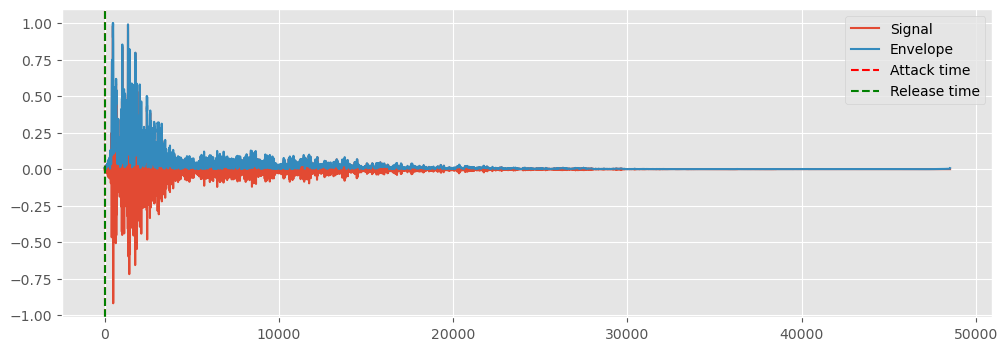

In [57]:
# plot the signal with attack and release times on the same plot

def plot_attack_release(y, sr, threshold=0.5):
    """
    Affiche le signal audio avec les temps d'attaque et de relâchement.

    Args:
        y (np.ndarray): Le signal audio.
        sr (int): Le taux d'échantillonnage du signal audio.
        threshold (float): Le seuil pour détecter le relâchement du signal audio.
    """
    # Calcul de l'enveloppe analytique
    y_analytic = hilbert(y)
    y_env = np.abs(y_analytic)

    # Calcul du log du temps d'attaque
    log_attack_time, attack_time = get_attack_time(y, sr)

    # Calcul du log du temps de relâchement
    log_release_time, release_time = get_release_time(y, sr, threshold)

    # Affichage du signal audio
    plt.figure(figsize=(12, 4))
    plt.plot(y, label='Signal')
    plt.plot(y_env, label='Envelope')
    plt.axvline(x=attack_time, color='r', linestyle='--', label='Attack time')
    plt.axvline(x=release_time, color='g', linestyle='--', label='Release time')
    plt.legend()
    plt.show()

plot_attack_release(y1, sr1)

### Temporal centroid

In [66]:
get_attack_time(y1, sr1), get_release_time(y1, sr1)

((-1.969577448730027, 0.01072562358276644), (0, 0.0))

In [69]:
def get_temporal_centroid(y, sr):
    energy = np.sum(y ** 2)
    energy_cumulative = np.cumsum(y ** 2)
    half_energy_time = np.argmax(energy_cumulative >= 0.5 * energy)
    return half_energy_time / sr

get_temporal_centroid(y1, sr1)

0.03217687074829932

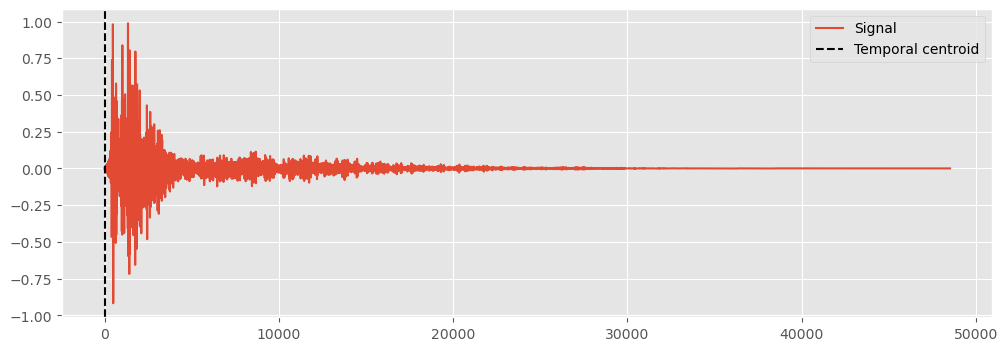

In [70]:
# plot the signal with the temporal centroid on the same plot

def plot_temporal_centroid(y, sr):
    """
    Affiche le signal audio avec le centre temporel.

    Args:
        y (np.ndarray): Le signal audio.
        sr (int): Le taux d'échantillonnage du signal audio.
    """
    # Calcul du centre temporel
    temporal_centroid = get_temporal_centroid(y, sr)

    # Affichage du signal audio
    plt.figure(figsize=(12, 4))
    plt.plot(y, label='Signal')
    plt.axvline(x=temporal_centroid, color='black', linestyle='--', label='Temporal centroid')
    plt.legend()
    plt.show()

plot_temporal_centroid(y1, sr1)

### Spectral centroid

In [ ]:
def get_spectral_centroid(y, sr):
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    return np.mean(spec_cent)

### Spectral bandwidth

In [ ]:
def get_spectral_bandwidth(y, sr):
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    return np.mean(spec_bw)

spec_bw = get_spectral_bandwidth(y1, sr1)

### Spectral rolloff

In [71]:
def spectral_rolloff(y, sr, roll_percent=0.85):
    spec_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=roll_percent)
    return np.mean(spec_rolloff)

rolloff_15 = spectral_rolloff(y1, sr1, roll_percent=0.15)
rolloff_85 = spectral_rolloff(y1, sr1, roll_percent=0.85)

7235.3829152960525

### • Extract features

In [ ]:
def extract_features(file_path : str

## Save the dataset

In [66]:
dataset

,file_path,file_name,file_extension,class,split,duration
0,G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...,Clap 0000,.flac,Clap,train,1.509683
1,G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...,Clap 0001,.flac,Clap,train,1.100000
2,G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...,Clap 0002,.flac,Clap,test,0.343605
3,G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...,Clap 0003,.flac,Clap,test,0.872449
4,G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...,Clap 0004,.flac,Clap,train,0.309116
...,...,...,...,...,...,...
7635,G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...,Tom 0995,.flac,Tom,train,3.058503
7636,G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...,Tom 0996,.flac,Tom,test,0.312494
7637,G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...,Tom 0997,.flac,Tom,train,0.500000
7638,G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...,Tom 0998,.flac,Tom,train,1.664921


In [64]:
dataset.to_csv(os.path.join(SOUNDS_DATASET_PATH,"dataset_handcrafted_features_extracted.csv"))